In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from pyod.models.knn import KNN 

from sklearn.feature_selection import( 
    RFECV,
    SequentialFeatureSelector,
    SelectFromModel
)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import(
    RandomForestClassifier,
    HistGradientBoostingClassifier
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from src.analyses import graphic_anomalies
from src.wrapped import Wrapped
from src.train import cross_validate_balancead, train_feature_combination

In [3]:
wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

# Importando dados para treinamento

In [4]:
df = wp.load_data('df_instrumentos_features_selecionadas')

In [5]:
# instrumentos aerofone
inst_aerofone = ["accordion", "organ", "piano"] 

df = df[df['instrumento'].isin(inst_aerofone)]

- Definindo as variaveis de treino e o target

In [6]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df.instrumento)

In [7]:
X = df.drop(columns=['labels', 'instrumento','file_name'])
y = df['labels'].to_frame()

# TESTE 1: Balanceamento

- 1° Opção: Balanceamento das classes com SMOTH

In [8]:
t1_models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    MLPClassifier(),
    SVC(),
])

t1_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X, y=y, oversampling=True) for model in t1_models]

dict_results_t1 = {
    'Naive Bayes': t1_acuracy_models[0],
    'KNN': t1_acuracy_models[1],
    'Arvore de Decisão': t1_acuracy_models[2],
    'Floresta Aleatoria': t1_acuracy_models[3],
    'HistGradientBoosting': t1_acuracy_models[4],
    'LIGHTGBM': t1_acuracy_models[5],
    'MLP': t1_acuracy_models[6],
    'SVC': t1_acuracy_models[7],
}

dict_results_t1

Acuracia do modelo GaussianNB() do Fold 0: 0.6485714285714286
Acuracia do modelo GaussianNB() do Fold 1: 0.66
Acuracia do modelo GaussianNB() do Fold 2: 0.6914285714285714
Acuracia do modelo GaussianNB() do Fold 3: 0.6542857142857142
Acuracia do modelo GaussianNB() do Fold 4: 0.6857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.58
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6142857142857143
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5885714285714285
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5571428571428572
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.62
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5857142857142857
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5971428571428572
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5285714285714286
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5714285714285714
Acuracia do modelo DecisionTreeClassifier() do Fold 4: 0.6314285714285715
Ac

{'Naive Bayes': 0.6679999999999999,
 'KNN': 0.592,
 'Arvore de Decisão': 0.582857142857143,
 'Floresta Aleatoria': 0.7085714285714285,
 'HistGradientBoosting': 0.7365714285714285,
 'LIGHTGBM': 0.7394285714285714,
 'MLP': 0.6251428571428572,
 'SVC': 0.6137142857142857}

- 2° Opção: Class Weight

In [9]:
models_class_weight = np.array([
    DecisionTreeClassifier(class_weight='balanced'), 
    RandomForestClassifier(class_weight='balanced', random_state = 0, n_jobs = -1), 
    LGBMClassifier(class_weight='balanced'),
])

t1_acuracy_models_class_weight = [cross_validate_balancead(k=5, model=model, X=X, y=y, weight=True) for model in models_class_weight]

dict_results_t1_class_weight = {
    'Arvore de Decisão': t1_acuracy_models_class_weight[0],
    'Floresta Aleatoria': t1_acuracy_models_class_weight[1],
    'LIGHTGBM': t1_acuracy_models_class_weight[2],
}

dict_results_t1_class_weight

Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 0: 0.6057142857142858
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 1: 0.6314285714285715
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 2: 0.5857142857142857
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 3: 0.6
Acuracia do modelo DecisionTreeClassifier(class_weight='balanced') do Fold 4: 0.6085714285714285
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 0: 0.6771428571428572
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 1: 0.7142857142857143
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 2: 0.7142857142857143
Acuracia do modelo RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0) do Fold 3: 0.7142857142857143
Acuracia do modelo RandomForestCla

{'Arvore de Decisão': 0.6062857142857143,
 'Floresta Aleatoria': 0.7120000000000001,
 'LIGHTGBM': 0.7405714285714287}

# TESTE 2: Remover Outlier

- Treinar modelo de classificação de outilier

In [13]:
detector_outilier = KNN()

new_df = df.drop(columns=['instrumento','file_name'])

detector_outilier.fit(new_df)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

- Checar numeros de outilers e não outilers<br/>
**0 (False) Não é outiler**<br/>
**1 (True) É outiler**

In [14]:
previsions = detector_outilier.labels_
np.unique(previsions, return_counts=True)

(array([0, 1]), array([1576,  174]))

- Distancia euclidiana dos registros

In [15]:
confiance_previsions = detector_outilier.decision_scores_
confiance_previsions

array([879.52597165, 485.61925518, 469.93615338, ..., 393.4113039 ,
       708.25321334, 312.90606476])

- Grafico

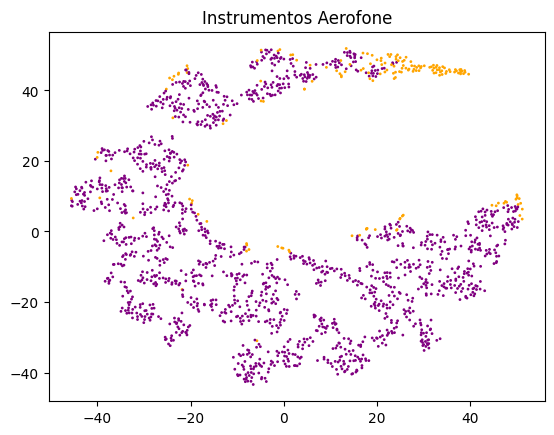

In [16]:
graphic_anomalies(df.drop(columns=['instrumento','file_name']), 'Instrumentos Aerofone')

- Checar os outilers

In [17]:
# pegando indice dos registros que são outilers
outilers_id = [previsions[i] == 1 for i in range(previsions.shape[0])]
outilers = df.iloc[outilers_id,:]
outilers

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
3     0.157274 -0.066099  0.209729  0.338755  0.660264  0.256625  0.275209   
11    0.067479 -0.072520  0.319265  0.259853  0.236549  0.416537  0.552991   
28    0.177880  0.099179  0.446227  0.186154  0.310970  0.289374  0.480033   
35   -0.231209 -0.164767  0.777508  0.578240  0.235910  0.271922  0.123425   
46    0.001389  0.058207  0.307783  0.359920  0.321503  0.340189  0.230577   
...        ...       ...       ...       ...       ...       ...       ...   
5762  0.320744  0.333888  0.157782  0.363536  0.682014  0.422248  0.271323   
5763  0.015400  0.123637  0.372522  0.159783  0.299456  0.384501  0.292673   
5771 -0.272394 -0.220975  0.386687  0.572144  0.377248  0.291276  0.279419   
5819  0.027706  0.089406  0.434948  0.125371  0.231317  0.110108  0.047079   
5836 -0.042766 -0.251569  0.054530  0.159495  0.063132  0.040510  0.032541   

       chroma6   chroma7       mfcc0  ...  spectral_centroid  spectral_onset  \
3     0.180417  0.399448  -66.319801  ...        2903.979876        1.218963   
11    0.282335  0.311797  -94.087822  ...        2669.619821        1.465200   
28    0.271526  0.262448 -113.129501  ...        3178.625677        1.504104   
35    0.241857  0.367082  -22.823570  ...        2150.842674        0.733548   
46    0.230887  0.267941 -335.472443  ...        3317.306522        1.480623   
...        ...       ...         ...  ...                ...             ...   
5762  0.336627  0.666637 -345.862030  ...         357.755105        0.542614   
5763  0.341428  0.091393 -226.478699  ...         942.045483        1.311127   
5771  0.360151  0.437108 -318.811493  ...         499.685219        0.679895   
5819  0.052817  0.032457 -330.949127  ...        1205.187669        1.246012   
5836  0.214021  0.976086 -318.622833  ...        1434.749693        1.063645   

      spectral_rolloff  spectogram  mel_spectogram  zero_crossing_rate  \
3          6751.133809  -42.723160      -44.649315            0.144010   
11         6189.322048  -46.716263      -67.817337            0.096043   
28         5658.636007  -64.840324      -79.991013            0.225914   
35         4609.279553  -52.478855      -73.244209            0.110248   
46         6072.413242  -37.332355      -79.453758            0.249911   
...                ...         ...             ...                 ...   
5762        697.306070  -28.129459      -64.974831            0.018301   
5763       1374.577767  -37.704166      -79.981483            0.079346   
5771       1074.961481  -52.980217      -61.614857            0.017695   
5819       1720.058277  -59.069580      -72.654686            0.129964   
5836       2117.723080  -59.973610      -65.730003            0.081683   

      zero_crossing  instrumento           file_name  labels  
3             31836    accordion   000212_211200.ogg       0  
11            21237    accordion    004073_30720.ogg       0  
28            49936    accordion   011547_157440.ogg       0  
35            24359    accordion   013463_195840.ogg       0  
46            55267    accordion   019554_199680.ogg       0  
...             ...          ...                 ...     ...  
5762           4058        piano     109200_3840.ogg       2  
5763          17538        piano     109282_7680.ogg       2  
5771           3918        piano  112068_1566720.ogg       2  
5819          28728        piano   119297_195840.ogg       2  
5836          18146        piano        122656_0.ogg       2  

[174 rows x 47 columns]

In [18]:
outilers.instrumento.value_counts()

accordion    97
organ        59
piano        18
Name: instrumento, dtype: int64

- Agora vamos remover os outilers da nossa base

In [19]:
# pegando indice dos registros que não são outilers
outilers_id =[previsions[i] == 0 for i in range(previsions.shape[0])]
df_train = df.iloc[outilers_id,:]
df_train

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
0     0.010380  0.038218  0.513887  0.581963  0.434641  0.293949  0.317826   
1     0.084643 -0.035337  0.175587  0.429345  0.840043  0.384524  0.282545   
2    -0.030127  0.082404  0.453814  0.219808  0.228484  0.446050  0.178916   
4    -0.049096 -0.029067  0.484400  0.334572  0.441629  0.679485  0.382958   
5    -0.180964  0.569503  0.371429  0.329753  0.127768  0.165817  0.210350   
...        ...       ...       ...       ...       ...       ...       ...   
5983  0.306987  0.197302  0.181270  0.482163  0.806090  0.410171  0.182062   
5984  0.339596  0.193580  0.309043  0.115449  0.066983  0.121548  0.543438   
5985  0.022141  0.249860  0.019285  0.019074  0.026441  0.062063  0.285675   
5986 -0.038987  0.185848  0.182197  0.123432  0.274012  0.223736  0.119671   
5987 -0.283267  0.167547  0.088772  0.062575  0.133157  0.320879  0.150541   

       chroma6   chroma7       mfcc0  ...  spectral_centroid  spectral_onset  \
0     0.271148  0.548258  -24.170067  ...        2600.055158        1.098243   
1     0.346341  0.482365  -90.556145  ...        2385.271420        1.360742   
2     0.250981  0.327460 -106.124260  ...        2069.850731        1.343197   
4     0.326033  0.205775 -226.263824  ...        1251.374287        1.339527   
5     0.864152  0.316520 -139.586807  ...        1213.792172        0.863256   
...        ...       ...         ...  ...                ...             ...   
5983  0.128068  0.223802 -208.045074  ...         821.680671        0.769584   
5984  0.246675  0.126754 -359.998535  ...         704.896231        0.654192   
5985  0.762290  0.256367 -342.691559  ...         647.666659        0.788650   
5986  0.259500  0.083546 -192.736328  ...        1094.419047        1.140904   
5987  0.047910  0.133445 -281.396088  ...         604.108430        0.822536   

      spectral_rolloff  spectogram  mel_spectogram  zero_crossing_rate  \
0          5260.821321  -44.640682      -30.202150            0.149672   
1          5225.124166  -46.575737      -59.323132            0.112181   
2          4287.155824  -56.276707      -71.512909            0.096007   
4          2263.034730  -62.227947      -78.196365            0.059804   
5          2477.767229  -66.244644      -79.955254            0.051793   
...                ...         ...             ...                 ...   
5983       1623.308746  -52.423000      -75.093781            0.038042   
5984       1007.089425  -73.745857      -80.000000            0.042257   
5985       1045.659338   -9.425838      -39.180683            0.026027   
5986       1788.779671  -25.643265      -72.219749            0.081838   
5987       1122.449439   -9.739196      -40.197876            0.039576   

      zero_crossing  instrumento          file_name  labels  
0             33095    accordion  000139_119040.ogg       0  
1             24785    accordion  000145_172800.ogg       0  
2             21230    accordion  000201_168960.ogg       0  
4             13214    accordion   000640_49920.ogg       0  
5             11451    accordion  000717_142080.ogg       0  
...             ...          ...                ...     ...  
5983           8414        piano   152057_38400.ogg       2  
5984           9343        piano   153905_72960.ogg       2  
5985           5747        piano  154231_199680.ogg       2  
5986          18093        piano   154374_92160.ogg       2  
5987           8752        piano  155278_211200.ogg       2  

[1576 rows x 47 columns]

- Treinar modelos sem outlier e balanceameto

In [20]:
X_rm_outilers = df_train.drop(columns=['labels', 'instrumento','file_name'])
y_rm_outilers = df_train['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    # XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t2_acuracy_models = [cross_validate_balancead(k=5, model=model, X=X_rm_outilers,  y=y_rm_outilers) for model in models]

dict_results_t2 = {
    'Naive Bayes': t2_acuracy_models[0],
    'KNN': t2_acuracy_models[1],
    'Arvore de Decisão': t2_acuracy_models[2],
    'Floresta Aleatoria': t2_acuracy_models[3],
    'HistGradientBoosting': t2_acuracy_models[4],
    'LIGHTGBM': t2_acuracy_models[5],
    # 'XGB': t2_acuracy_models[6],
    'MLP': t2_acuracy_models[6],
    'SVC': t2_acuracy_models[7],
}

dict_results_t2

Acuracia do modelo GaussianNB() do Fold 0: 0.6740506329113924
Acuracia do modelo GaussianNB() do Fold 1: 0.6730158730158731
Acuracia do modelo GaussianNB() do Fold 2: 0.6571428571428571
Acuracia do modelo GaussianNB() do Fold 3: 0.6761904761904762
Acuracia do modelo GaussianNB() do Fold 4: 0.6761904761904762
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5822784810126582
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6190476190476191
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5746031746031746
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5301587301587302
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6158730158730159
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5886075949367089
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6222222222222222
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5714285714285714
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6095238095238096
Acuracia do modelo DecisionTreeCla

{'Naive Bayes': 0.6713180630902151,
 'KNN': 0.5843922041390396,
 'Arvore de Decisão': 0.6053405666063895,
 'Floresta Aleatoria': 0.7132127787823991,
 'HistGradientBoosting': 0.7347880249146073,
 'LIGHTGBM': 0.7246252762708459,
 'MLP': 0.6105404862366888,
 'SVC': 0.6116857544705646}

# TESTE 3: Features por Correlação

In [21]:
df_corr = df.drop(columns=['instrumento', 'file_name', 'labels']).corr().unstack().reset_index().dropna()
df_corr.rename(columns = {'level_0': 'features_a', 'level_1': 'features_b', 0:'correlacao'}, inplace = True)
df_corr

features_a          features_b  correlacao
0          tonnetz0            tonnetz0    1.000000
1          tonnetz0            tonnetz1    0.065961
2          tonnetz0             chroma1   -0.011657
3          tonnetz0             chroma2   -0.127480
4          tonnetz0             chroma3    0.274282
...             ...                 ...         ...
1931  zero_crossing    spectral_rolloff    0.775831
1932  zero_crossing          spectogram   -0.037625
1933  zero_crossing      mel_spectogram   -0.036768
1934  zero_crossing  zero_crossing_rate    0.999998
1935  zero_crossing       zero_crossing    1.000000

[1936 rows x 3 columns]

- Correlação Positia

In [22]:
corr_posit = df_corr.query('correlacao > 0.5 and correlacao < 1.0')
corr_posit

features_a          features_b  correlacao
430           mfcc0      spectral_band2    0.654643
431           mfcc0      spectral_band3    0.605442
432           mfcc0      spectral_band4    0.555236
433           mfcc0   spectral_centroid    0.648655
435           mfcc0    spectral_rolloff    0.657413
...             ...                 ...         ...
1926  zero_crossing      spectral_band2    0.612711
1927  zero_crossing      spectral_band3    0.509144
1929  zero_crossing   spectral_centroid    0.854885
1931  zero_crossing    spectral_rolloff    0.775831
1934  zero_crossing  zero_crossing_rate    0.999998

[78 rows x 3 columns]

In [23]:
len(corr_posit.features_a.unique()), corr_posit.features_a.unique()

(22,
 array(['mfcc0', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc12',
        'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'spectral_band2',
        'spectral_band3', 'spectral_band4', 'spectral_centroid',
        'spectral_onset', 'spectral_rolloff', 'spectogram',
        'mel_spectogram', 'zero_crossing_rate', 'zero_crossing'],
       dtype=object))

In [24]:
X =  df[corr_posit.features_a.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_posit = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_posit = {
    'Naive Bayes': t3_acuracy_models_corr_posit[0],
    'KNN': t3_acuracy_models_corr_posit[1],
    'Arvore de Decisão': t3_acuracy_models_corr_posit[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_posit[3],
    'HistGradientBoosting': t3_acuracy_models_corr_posit[4],
    'LIGHTGBM': t3_acuracy_models_corr_posit[5],
    'XGB': t3_acuracy_models_corr_posit[6],
    'MLP': t3_acuracy_models_corr_posit[7],
    'SVC': t3_acuracy_models_corr_posit[8],
}

dict_results_t3_corr_posit

Acuracia do modelo GaussianNB() do Fold 0: 0.6514285714285715
Acuracia do modelo GaussianNB() do Fold 1: 0.64
Acuracia do modelo GaussianNB() do Fold 2: 0.6571428571428571
Acuracia do modelo GaussianNB() do Fold 3: 0.6371428571428571
Acuracia do modelo GaussianNB() do Fold 4: 0.6542857142857142
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5885714285714285
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6057142857142858
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.58
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.54
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6314285714285715
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5485714285714286
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5857142857142857
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5942857142857143
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6114285714285714
Acuracia do modelo DecisionTreeClassifier() do Fold 4: 0.5828571428571429
Ac

{'Naive Bayes': 0.6479999999999999,
 'KNN': 0.5891428571428572,
 'Arvore de Decisão': 0.5845714285714285,
 'Floresta Aleatoria': 0.6942857142857143,
 'HistGradientBoosting': 0.7005714285714286,
 'LIGHTGBM': 0.6971428571428572,
 'XGB': 0.6880000000000001,
 'MLP': 0.5434285714285714,
 'SVC': 0.5948571428571429}

- Correlação Negativa

In [25]:
corr_negat = df_corr.query('correlacao > -1.0 and correlacao < -0.5')
corr_negat

features_a          features_b  correlacao
474                mfcc1      spectral_band2   -0.887118
475                mfcc1      spectral_band3   -0.848760
476                mfcc1      spectral_band4   -0.792774
477                mfcc1   spectral_centroid   -0.876985
478                mfcc1      spectral_onset   -0.510477
479                mfcc1    spectral_rolloff   -0.864747
482                mfcc1  zero_crossing_rate   -0.661832
483                mfcc1       zero_crossing   -0.661931
1506      spectral_band2               mfcc1   -0.887118
1550      spectral_band3               mfcc1   -0.848760
1594      spectral_band4               mfcc1   -0.792774
1638   spectral_centroid               mfcc1   -0.876985
1682      spectral_onset               mfcc1   -0.510477
1726    spectral_rolloff               mfcc1   -0.864747
1858  zero_crossing_rate               mfcc1   -0.661832
1902       zero_crossing               mfcc1   -0.661931

In [26]:
len(corr_negat.features_b.unique()), corr_negat.features_b.unique()

(9,
 array(['spectral_band2', 'spectral_band3', 'spectral_band4',
        'spectral_centroid', 'spectral_onset', 'spectral_rolloff',
        'zero_crossing_rate', 'zero_crossing', 'mfcc1'], dtype=object))

In [27]:
X =  df[corr_negat.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_neg = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr_neg = {
    'Naive Bayes': t3_acuracy_models_corr_neg[0],
    'KNN': t3_acuracy_models_corr_neg[1],
    'Arvore de Decisão': t3_acuracy_models_corr_neg[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_neg[3],
    'HistGradientBoosting': t3_acuracy_models_corr_neg[4],
    'LIGHTGBM': t3_acuracy_models_corr_neg[5],
    'XGB': t3_acuracy_models_corr_neg[6],
    'MLP': t3_acuracy_models_corr_neg[7],
    'SVC': t3_acuracy_models_corr_neg[8],
}

dict_results_t3_corr_neg

Acuracia do modelo GaussianNB() do Fold 0: 0.5942857142857143
Acuracia do modelo GaussianNB() do Fold 1: 0.5857142857142857
Acuracia do modelo GaussianNB() do Fold 2: 0.62
Acuracia do modelo GaussianNB() do Fold 3: 0.5914285714285714
Acuracia do modelo GaussianNB() do Fold 4: 0.6142857142857143
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5914285714285714
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6057142857142858
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5685714285714286
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5285714285714286
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6314285714285715
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5771428571428572
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.58
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5371428571428571
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.62
Acuracia do modelo DecisionTreeClassifier() do Fold 4: 0.5857142857142857
Ac

{'Naive Bayes': 0.6011428571428572,
 'KNN': 0.5851428571428571,
 'Arvore de Decisão': 0.58,
 'Floresta Aleatoria': 0.6519999999999999,
 'HistGradientBoosting': 0.6485714285714286,
 'LIGHTGBM': 0.6468571428571429,
 'XGB': 0.6542857142857142,
 'MLP': 0.4565714285714286,
 'SVC': 0.6017142857142856}

- Se combinarmos as duas abordagens ?

In [28]:
features = np.append(corr_posit.features_b.unique(), corr_negat.features_b.unique())
features

array(['spectral_band2', 'spectral_band3', 'spectral_band4',
       'spectral_centroid', 'spectral_rolloff', 'mfcc7', 'mfcc6', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc13', 'mfcc12', 'mfcc14', 'mfcc15',
       'mfcc16', 'mfcc17', 'mfcc0', 'spectral_onset',
       'zero_crossing_rate', 'zero_crossing', 'mel_spectogram',
       'spectogram', 'spectral_band2', 'spectral_band3', 'spectral_band4',
       'spectral_centroid', 'spectral_onset', 'spectral_rolloff',
       'zero_crossing_rate', 'zero_crossing', 'mfcc1'], dtype=object)

In [29]:
features = np.append(corr_posit.features_b.unique(), corr_negat.features_b.unique())
features = np.unique(features)

X = df[features]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_combine_corr = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_cb = {
    'Naive Bayes': t3_combine_corr[0],
    'KNN': t3_combine_corr[1],
    'Arvore de Decisão': t3_combine_corr[2],
    'Floresta Aleatoria': t3_combine_corr[3],
    'HistGradientBoosting': t3_combine_corr[4],
    'LIGHTGBM': t3_combine_corr[5],
    'XGB': t3_combine_corr[6],
    'MLP': t3_combine_corr[7],
    'SVC': t3_combine_corr[8],
}

dict_results_t3_cb

Acuracia do modelo GaussianNB() do Fold 0: 0.6514285714285715
Acuracia do modelo GaussianNB() do Fold 1: 0.64
Acuracia do modelo GaussianNB() do Fold 2: 0.6714285714285714
Acuracia do modelo GaussianNB() do Fold 3: 0.6485714285714286
Acuracia do modelo GaussianNB() do Fold 4: 0.6685714285714286
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5885714285714285
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6057142857142858
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.58
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.54
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6314285714285715
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5171428571428571
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5542857142857143
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5657142857142857
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6371428571428571
Acuracia do modelo DecisionTreeClassifier() do Fold 4: 0.5885714285714285
Ac

{'Naive Bayes': 0.6559999999999999,
 'KNN': 0.5891428571428572,
 'Arvore de Decisão': 0.5725714285714285,
 'Floresta Aleatoria': 0.7074285714285715,
 'HistGradientBoosting': 0.7091428571428572,
 'LIGHTGBM': 0.7011428571428572,
 'XGB': 0.6994285714285715,
 'MLP': 0.6217142857142857,
 'SVC': 0.5948571428571429}

- Correlação de -0.5 a 0.5

In [30]:
corr_prox_zero = df_corr.query('correlacao > -0.5 and correlacao < 0.5')
corr_prox_zero

features_a      features_b  correlacao
1          tonnetz0        tonnetz1    0.065961
2          tonnetz0         chroma1   -0.011657
3          tonnetz0         chroma2   -0.127480
4          tonnetz0         chroma3    0.274282
5          tonnetz0         chroma4   -0.253882
...             ...             ...         ...
1925  zero_crossing        chroma12    0.104764
1928  zero_crossing  spectral_band4    0.418041
1930  zero_crossing  spectral_onset    0.402864
1932  zero_crossing      spectogram   -0.037625
1933  zero_crossing  mel_spectogram   -0.036768

[1798 rows x 3 columns]

In [31]:
len(corr_prox_zero.features_b.unique())

44

In [32]:
X =  df[corr_prox_zero.features_b.unique()]
y = df['labels'].to_frame()

models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t3_acuracy_models_corr_prox_zero = [cross_validate_balancead(k=5, model=model, X=X, y=y) for model in models]

dict_results_t3_corr = {
    'Naive Bayes': t3_acuracy_models_corr_prox_zero[0],
    'KNN': t3_acuracy_models_corr_prox_zero[1],
    'Arvore de Decisão': t3_acuracy_models_corr_prox_zero[2],
    'Floresta Aleatoria': t3_acuracy_models_corr_prox_zero[3],
    'HistGradientBoosting': t3_acuracy_models_corr_prox_zero[4],
    'LIGHTGBM': t3_acuracy_models_corr_prox_zero[5],
    'XGB': t3_acuracy_models_corr_prox_zero[6],
    'MLP': t3_acuracy_models_corr_prox_zero[7],
    'SVC': t3_acuracy_models_corr_prox_zero[8],
}

dict_results_t3_corr

Acuracia do modelo GaussianNB() do Fold 0: 0.6514285714285715
Acuracia do modelo GaussianNB() do Fold 1: 0.6628571428571428
Acuracia do modelo GaussianNB() do Fold 2: 0.6971428571428572
Acuracia do modelo GaussianNB() do Fold 3: 0.6571428571428571
Acuracia do modelo GaussianNB() do Fold 4: 0.6857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6057142857142858
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.58
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.54
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6314285714285715
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5914285714285714
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6657142857142857
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5742857142857143
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5914285714285714
Acuracia do modelo DecisionTreeClassifier() do Fold 4: 0.62285

{'Naive Bayes': 0.6708571428571428,
 'KNN': 0.5885714285714286,
 'Arvore de Decisão': 0.6091428571428571,
 'Floresta Aleatoria': 0.7228571428571428,
 'HistGradientBoosting': 0.7274285714285714,
 'LIGHTGBM': 0.7342857142857143,
 'XGB': 0.7411428571428571,
 'MLP': 0.5697142857142857,
 'SVC': 0.5960000000000001}

# TESTE4: Recursive Feature Elimination - (RFE)

- RFE

In [33]:
X = df.drop(columns=['instrumento','file_name','labels'])
y = df['labels'].to_frame()

clf = DecisionTreeClassifier(max_depth=17,
                             max_features='auto', 
                             min_samples_leaf=2,
                             min_samples_split=3)
                               
                               
estimators = RFECV(estimator=clf, scoring='accuracy', cv=5)

# fit rfecv
rfecv_data = estimators.fit(X, y)

# gorresponde à posição do ranking do i-ésimo recurso
ranking_features = rfecv_data.ranking_

# A máscara dos recursos selecionados.
support_features = rfecv_data.support_

# filtro
features_selects = X.columns[support_features]

In [34]:
features_selects

Index(['tonnetz0', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc7',
       'mfcc8', 'mfcc9', 'mfcc10', 'mfcc14', 'chroma9', 'chroma11',
       'spectral_centroid', 'spectral_onset', 'zero_crossing_rate'],
      dtype='object')

In [ ]:
ranking_features.shape

(44,)

- Count Ranking Features

In [ ]:
# Couts da features import 
unique, frequency = np.unique(ranking_features, return_counts=True)
summary = np.asarray((unique, frequency)).T
summary

array([[ 1, 16],
       [ 2,  1],
       [ 3,  1],
       [ 4,  1],
       [ 5,  1],
       [ 6,  1],
       [ 7,  1],
       [ 8,  1],
       [ 9,  1],
       [10,  1],
       [11,  1],
       [12,  1],
       [13,  1],
       [14,  1],
       [15,  1],
       [16,  1],
       [17,  1],
       [18,  1],
       [19,  1],
       [20,  1],
       [21,  1],
       [22,  1],
       [23,  1],
       [24,  1],
       [25,  1],
       [26,  1],
       [27,  1],
       [28,  1],
       [29,  1]])

- Treinamento de Modelo

In [ ]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t4_acuracy_models = [cross_validate_balancead(k=5, 
                                              model=model,
                                              X=X, 
                                              y=y, 
                                              oversampling=True) for model in models]

dict_results_t4 = {
    'Naive Bayes': t4_acuracy_models[0],
    'KNN': t4_acuracy_models[1],
    'Arvore de Decisão': t4_acuracy_models[2],
    'Floresta Aleatoria': t4_acuracy_models[3],
    'HistGradientBoosting': t4_acuracy_models[4],
    'LIGHTGBM': t4_acuracy_models[5],
    'XGB': t4_acuracy_models[6],
    'MLP': t4_acuracy_models[7],
    'SVC': t4_acuracy_models[8],
}

dict_results_t4

Acuracia do modelo GaussianNB() do Fold 0: 0.6485714285714286
Acuracia do modelo GaussianNB() do Fold 1: 0.66
Acuracia do modelo GaussianNB() do Fold 2: 0.6914285714285714
Acuracia do modelo GaussianNB() do Fold 3: 0.6542857142857142
Acuracia do modelo GaussianNB() do Fold 4: 0.6857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.58
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6142857142857143
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5885714285714285
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5571428571428572
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.62
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5714285714285714
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5971428571428572
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5457142857142857
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5685714285714286
Acuracia do modelo DecisionTreeClassifier() do Fold 4: 0.6257142857142857
Ac

{'Naive Bayes': 0.6679999999999999,
 'KNN': 0.592,
 'Arvore de Decisão': 0.5817142857142856,
 'Floresta Aleatoria': 0.7211428571428572,
 'HistGradientBoosting': 0.7365714285714285,
 'LIGHTGBM': 0.7394285714285714,
 'XGB': 0.7331428571428571,
 'MLP': 0.6519999999999999,
 'SVC': 0.6137142857142857}

# Teste 5: SequentialFeatureSelector

### Forward

In [ ]:
def selectorSequential(k, model_estimator, n_features, X, y):
    sfs = SequentialFeatureSelector(
        cv=k, 
        # direction = 'forward',
        n_features_to_select = n_features,
        estimator=model_estimator
    ).fit(X, y)
    
    mask_feature = sfs.get_support()
    
    return X[X.columns[mask_feature]]

In [ ]:
_X = selectorSequential(5, DecisionTreeClassifier(), 30, X, y)

In [ ]:
_X

tonnetz0  tonnetz1   chroma1   chroma2   chroma3   chroma4   chroma5  \
0     0.010380  0.038218  0.513887  0.581963  0.434641  0.293949  0.317826   
1     0.084643 -0.035337  0.175587  0.429345  0.840043  0.384524  0.282545   
2    -0.030127  0.082404  0.453814  0.219808  0.228484  0.446050  0.178916   
3     0.157274 -0.066099  0.209729  0.338755  0.660264  0.256625  0.275209   
4    -0.049096 -0.029067  0.484400  0.334572  0.441629  0.679485  0.382958   
...        ...       ...       ...       ...       ...       ...       ...   
5983  0.306987  0.197302  0.181270  0.482163  0.806090  0.410171  0.182062   
5984  0.339596  0.193580  0.309043  0.115449  0.066983  0.121548  0.543438   
5985  0.022141  0.249860  0.019285  0.019074  0.026441  0.062063  0.285675   
5986 -0.038987  0.185848  0.182197  0.123432  0.274012  0.223736  0.119671   
5987 -0.283267  0.167547  0.088772  0.062575  0.133157  0.320879  0.150541   

       chroma7       mfcc0       mfcc1  ...     mfcc17    mfcc18     mfcc19  \
0     0.548258  -24.170067   77.906380  ...   7.555676  1.468902  10.498053   
1     0.482365  -90.556145   89.083580  ...   5.749533 -2.110756  -3.542143   
2     0.327460 -106.124260   93.124458  ...   0.198734 -4.846475   7.278521   
3     0.399448  -66.319801   78.344582  ...   7.237651  0.069198   1.122705   
4     0.205775 -226.263824  147.787064  ...  -0.787216 -1.997669  -0.640013   
...        ...         ...         ...  ...        ...       ...        ...   
5983  0.223802 -208.045074  218.784363  ...  -8.232142 -4.514004   0.061071   
5984  0.126754 -359.998535  182.519424  ...   0.637529  0.944461   3.444711   
5985  0.256367 -342.691559  155.418442  ...   2.299892  9.979400  18.423162   
5986  0.083546 -192.736328  203.023346  ...  -3.728729 -5.214631  -9.698064   
5987  0.133445 -281.396088  219.986618  ...  15.834103  5.621994  -2.147173   

       chroma8  spectral_band2  spectral_band3  spectral_band4  \
0     0.660767     2453.749893     2949.581321     3409.640722   
1     0.321750     2527.109951     3038.064172     3516.595715   
2     0.333150     2181.821345     2735.690428     3256.491175   
3     0.381560     2985.879108     3446.105958     3855.791675   
4     0.309727     1533.896461     2223.101638     2883.225952   
...        ...             ...             ...             ...   
5983  0.209973      910.519592     1277.163672     1710.803257   
5984  0.375308      915.511305     1681.556710     2431.230598   
5985  0.474692      968.124935     1672.357525     2406.899185   
5986  0.123066      781.513943     1112.070824     1570.408078   
5987  0.676211      730.010045     1187.606544     1753.157109   

      spectral_centroid  spectral_onset  spectral_rolloff  
0           2600.055158        1.098243       5260.821321  
1           2385.271420        1.360742       5225.124166  
2           2069.850731        1.343197       4287.155824  
3           2903.979876        1.218963       6751.133809  
4           1251.374287        1.339527       2263.034730  
...                 ...             ...               ...  
5983         821.680671        0.769584       1623.308746  
5984         704.896231        0.654192       1007.089425  
5985         647.666659        0.788650       1045.659338  
5986        1094.419047        1.140904       1788.779671  
5987         604.108430        0.822536       1122.449439  

[1750 rows x 30 columns]

In [ ]:
models = np.array([
    GaussianNB(),
    KNeighborsClassifier(), 
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    HistGradientBoostingClassifier(),
    LGBMClassifier(),
    XGBClassifier(),
    MLPClassifier(),
    SVC(),
])

t5_acuracy_models = [cross_validate_balancead(k=5, 
                                              model=model,
                                              X=_X, 
                                              y=y, 
                                              oversampling=True) for model in models]

dict_results_t5 = {
    'Naive Bayes':t5_acuracy_models[0],
    'KNN':t5_acuracy_models[1],
    'Arvore de Decisão': t5_acuracy_models[2],
    'Floresta Aleatoria':t5_acuracy_models[3],
    'HistGradientBoosting':t5_acuracy_models[4],
    'LIGHTGBM': t5_acuracy_models[5],
    'XGB': t5_acuracy_models[6],
    'MLP': t5_acuracy_models[7],
    'SVC': t5_acuracy_models[8],
}

dict_results_t5

Acuracia do modelo GaussianNB() do Fold 0: 0.6828571428571428
Acuracia do modelo GaussianNB() do Fold 1: 0.6628571428571428
Acuracia do modelo GaussianNB() do Fold 2: 0.6971428571428572
Acuracia do modelo GaussianNB() do Fold 3: 0.6685714285714286
Acuracia do modelo GaussianNB() do Fold 4: 0.6857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5742857142857143
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5857142857142857
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5942857142857143
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.6314285714285715
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6485714285714286
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.58
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6314285714285715
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6057142857142858
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5971428571428572
Acuracia do modelo DecisionTreeClassifier() do F

{'Naive Bayes': 0.6794285714285714,
 'KNN': 0.606857142857143,
 'Arvore de Decisão': 0.6040000000000001,
 'Floresta Aleatoria': 0.7142857142857142,
 'HistGradientBoosting': 0.7302857142857142,
 'LIGHTGBM': 0.732,
 'XGB': 0.7245714285714285,
 'MLP': 0.6234285714285713,
 'SVC': 0.6154285714285714}

# Teste 6: Combinação

- Variaveis de  0 a 15 - combinações de 10

In [42]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(0, 15),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc0'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5828571428571429
Acuracia do modelo GaussianNB() do Fold 1: 0.5628571428571428
Acuracia do modelo GaussianNB() do Fold 2: 0.5857142857142857
Acuracia do modelo GaussianNB() do Fold 3: 0.5342857142857143
Acuracia do modelo GaussianNB() do Fold 4: 0.5457142857142857
Accuracy 0.5622857142857143 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc1'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6228571428571429
Acuracia do modelo GaussianNB() do Fold 1: 0.5714285714285714
Acuracia do modelo GaussianNB() do Fold 2: 0.6542857142857142
Acuracia do modelo GaussianNB() do Fold 3: 0.6228571428571429
Acuracia do 

defaultdict(list, {})

- Variaveis de  15 a 30 - combinações de 10

In [43]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(15, 30),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc15'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.56
Acuracia do modelo GaussianNB() do Fold 1: 0.5057142857142857
Acuracia do modelo GaussianNB() do Fold 2: 0.5371428571428571
Acuracia do modelo GaussianNB() do Fold 3: 0.5314285714285715
Acuracia do modelo GaussianNB() do Fold 4: 0.5257142857142857
Accuracy 0.532 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12',
       'mfcc13', 'mfcc14', 'mfcc16'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.5457142857142857
Acuracia do modelo GaussianNB() do Fold 1: 0.5114285714285715
Acuracia do modelo GaussianNB() do Fold 2: 0.54
Acuracia do modelo GaussianNB() do Fold 3: 0.5142857142857142
Acuracia do modelo GaussianNB() do Fold 4: 0.5371428571428571
Accuracy 0.52971428

defaultdict(list, {})

- Variaveis de 30 a 44 - combinações de 10

In [44]:
train_feature_combination(
    model = GaussianNB(),
    df = df,
    list_features = np.arange(30, 44),
    size_comb = 10
)

Teste 1 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectral_rolloff'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6114285714285714
Acuracia do modelo GaussianNB() do Fold 1: 0.5828571428571429
Acuracia do modelo GaussianNB() do Fold 2: 0.6228571428571429
Acuracia do modelo GaussianNB() do Fold 3: 0.6228571428571429
Acuracia do modelo GaussianNB() do Fold 4: 0.6171428571428571
Accuracy 0.6114285714285714 do teste -> 1
Teste 2 -> features Selecionada para o treino: Index(['chroma9', 'chroma10', 'chroma11', 'chroma12', 'spectral_band2',
       'spectral_band3', 'spectral_band4', 'spectral_centroid',
       'spectral_onset', 'spectogram'],
      dtype='object')
Acuracia do modelo GaussianNB() do Fold 0: 0.6114285714285714
Acuracia do modelo GaussianNB() do Fold 1: 0.62
Acuracia do modelo GaussianNB() do Fold 2:

defaultdict(list, {})